22:01:46 - cmdstanpy - INFO - Chain [1] start processing


CONSUMER BEHAVIOR PREDICTION - MODELING PIPELINE

Libraries loaded successfully!
- Pandas: 2.2.3
- NumPy: 1.26.4
- LightGBM: 4.6.0
- Prophet: Available
- SARIMAX: Available

CONFIGURATION
Forecast Horizon: 3 months
Test Set Size: 12 months
Target Variable: retail_sales_index
Random Seed: 42

LOADING DATA
 Dataset loaded: (72, 43)
  Date range: 2018-01-01 00:00:00 to 2023-12-01 00:00:00
  Total records: 72
  Total features: 43

First 5 rows:
        date  retail_sales_index  retail_sales_value_gbp_millions  \
0 2018-01-01          100.000000                     30000.000000   
1 2018-02-01           96.183428                     28855.028492   
2 2018-03-01           96.099267                     28829.779968   
3 2018-04-01           97.586842                     29276.052651   
4 2018-05-01          100.828076                     30248.422670   

   christmas gifts  black friday  boxing day sale  summer sale  discount  \
0              2.0           0.0              1.0         21.0  

22:01:46 - cmdstanpy - INFO - Chain [1] done processing


 Prophet model trained

 Prophet Model Results:
  RMSE: 176.2162
  MAE: 154.1935
  sMAPE: 7.4224
  MAPE: 13.6991
  R²: -0.3192
  Direction_Accuracy: 81.8182
 Model saved: prophet_model.pkl

MODEL 3: LIGHTGBM
Training gradient boosting model...
  Training in progress...
 LightGBM trained with 296 iterations

 LightGBM Model Results:
  RMSE: 502.2791
  MAE: 483.6053
  sMAPE: 28.5361
  MAPE: 44.2192
  R²: -9.7180
  Direction_Accuracy: 36.3636

 Top 10 Most Important Features:
                  feature   importance
       retail_sales_lag_6 3.596358e+06
       retail_sales_lag_5 2.452558e+06
        retail_sales_ma_3 1.928385e+06
          yoy_growth_rate 1.090548e+06
       retail_sales_lag_1 9.731605e+05
        retail_sales_ma_6 9.558075e+05
retail_sales_volatility_6 9.131106e+05
                     year 6.409320e+05
       retail_sales_lag_4 6.396919e+05
       retail_sales_lag_2 3.213126e+05

 Model saved: lightgbm_model.txt

MODEL 4: HYBRID (PROPHET + LIGHTGBM)
Combining Prophet tre

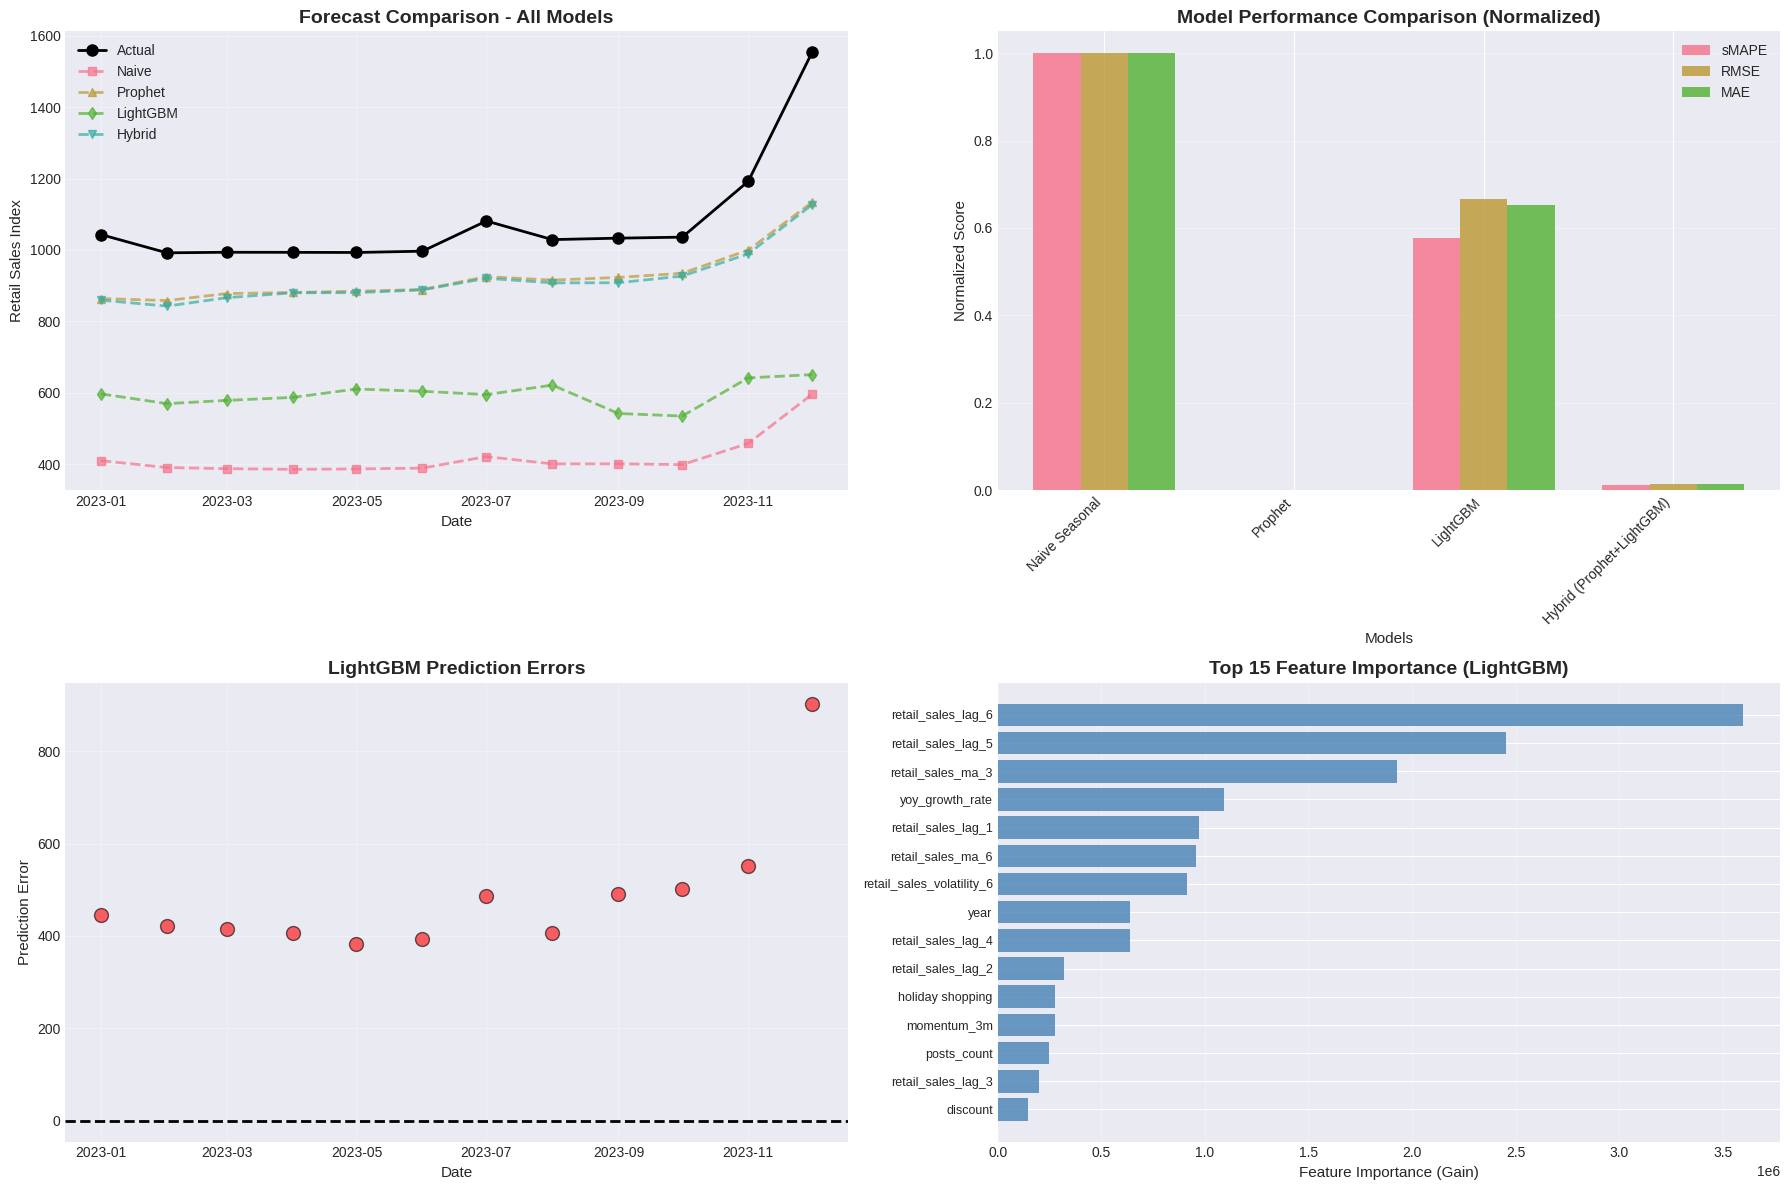

 Saved: best_model_forecast.png


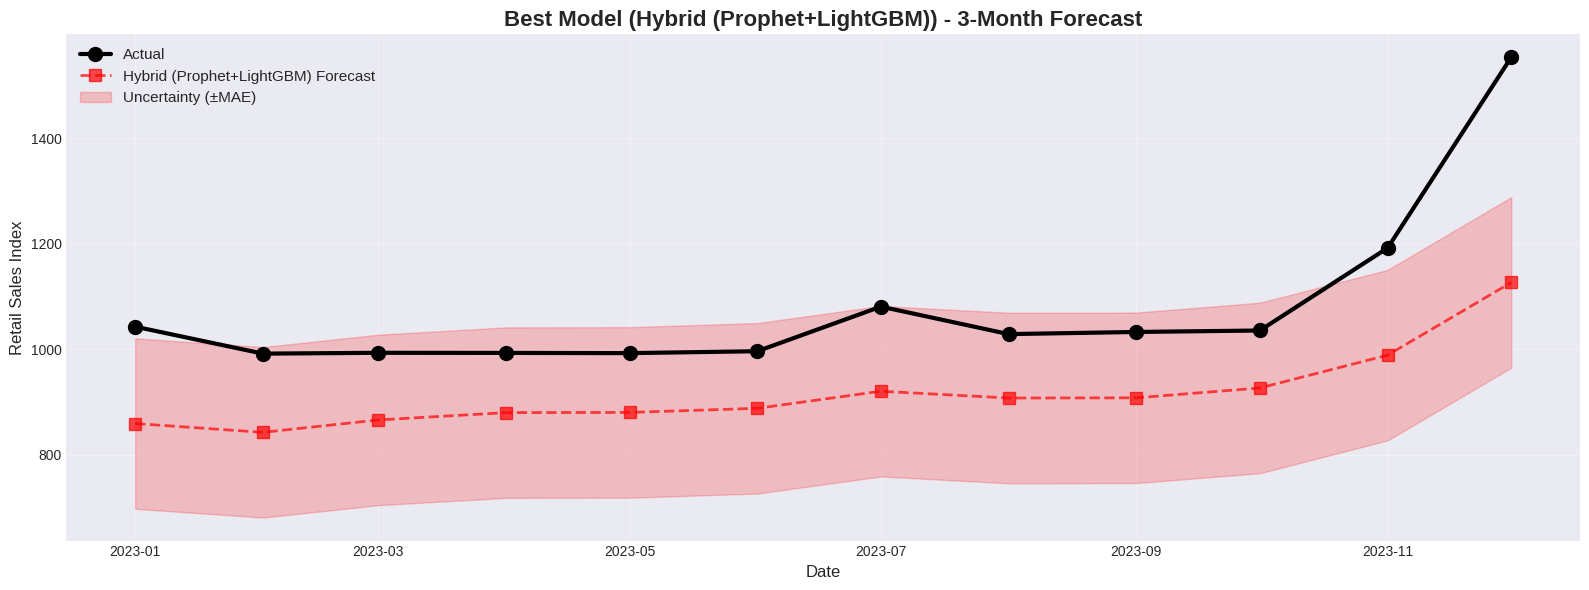


EXPORTING FORECASTS
 Saved: forecast_results.csv

Forecast Summary:
      date      actual  naive_forecast  lgb_forecast  prophet_forecast  hybrid_forecast  best_forecast  best_error  best_error_pct
2023-01-01 1043.049717      409.950419    596.913891        863.755298       859.363965     859.363965  183.685752       17.610450
2023-02-01  991.920677      390.649531    569.610835        858.266339       842.717294     842.717294  149.203383       15.041866
2023-03-01  993.533201      387.511490    578.681502        877.830657       866.194649     866.194649  127.338551       12.816738
2023-04-01  993.307597      385.630140    587.053105        880.824227       880.063240     880.063240  113.244357       11.400734
2023-05-01  992.901799      386.795123    610.555584        884.447790       880.434662     880.434662  112.467137       11.327116
2023-06-01  996.512654      389.045647    604.153061        889.157847       888.237745     888.237745  108.274909       10.865382
2023-07-01 108

In [2]:
# Consumer Behavior Prediction Service - Modeling & Evaluation Pipeline

"""
Project: Consumer Behavior Prediction Service for UK Retail  
Phase: Model Development and Evaluation  
Author: Data Science Team  
Date: October 2025

This notebook implements forecasting models for predicting retail sales 3 months in advance.
"""

# ============================================================================
# 1. SETUP AND CONFIGURATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Model libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# Time series libraries
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    print("Prophet not available. Install with: pip install prophet")
    PROPHET_AVAILABLE = False

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    SARIMAX_AVAILABLE = True
except ImportError:
    print("Statsmodels not available. Install with: pip install statsmodels")
    SARIMAX_AVAILABLE = False

# Model persistence
import pickle
import joblib

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("CONSUMER BEHAVIOR PREDICTION - MODELING PIPELINE")
print("=" * 80)
print("\nLibraries loaded successfully!")
print(f"- Pandas: {pd.__version__}")
print(f"- NumPy: {np.__version__}")
print(f"- LightGBM: {lgb.__version__}")
print(f"- Prophet: {'Available' if PROPHET_AVAILABLE else 'Not Available'}")
print(f"- SARIMAX: {'Available' if SARIMAX_AVAILABLE else 'Not Available'}")

# ============================================================================
# 2. CONFIGURATION
# ============================================================================

# Forecasting parameters
FORECAST_HORIZON = 3  # Predict 3 months ahead
TEST_SIZE = 12  # Use last 12 months for testing

# Model parameters
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Target variable
TARGET = 'retail_sales_index'

# Features to exclude from modeling
EXCLUDE_FEATURES = [
    'date', 
    'retail_sales_index',  # Target variable
    'retail_sales_value_gbp_millions'  # Alternative target
]

print("\n" + "=" * 80)
print("CONFIGURATION")
print("=" * 80)
print(f"Forecast Horizon: {FORECAST_HORIZON} months")
print(f"Test Set Size: {TEST_SIZE} months")
print(f"Target Variable: {TARGET}")
print(f"Random Seed: {RANDOM_SEED}")

# ============================================================================
# 3. LOAD PREPROCESSED DATA
# ============================================================================

print("\n" + "=" * 80)
print("LOADING DATA")
print("=" * 80)

# Load the preprocessed dataset
df = pd.read_csv('/kaggle/input/preprocessed/consumer_behavior_dataset_processed.csv')
df['date'] = pd.to_datetime(df['date'])

print(f" Dataset loaded: {df.shape}")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Total records: {len(df)}")
print(f"  Total features: {df.shape[1]}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

# ============================================================================
# 4. DATA PREPARATION
# ============================================================================

print("\n" + "=" * 80)
print("DATA PREPARATION")
print("=" * 80)

# Handle missing values (from lag features)
# For training, we'll drop rows with NaN in lag features
df_clean = df.dropna()
print(f" Removed rows with missing values: {len(df)} → {len(df_clean)}")

# Sort by date
df_clean = df_clean.sort_values('date').reset_index(drop=True)
print(f" Data sorted by date")

# Split into features and target
feature_columns = [col for col in df_clean.columns if col not in EXCLUDE_FEATURES]
X = df_clean[feature_columns]
y = df_clean[TARGET]

print(f"\n Features prepared: {len(feature_columns)} features")
print(f" Target prepared: {TARGET}")

# Time-based train/test split
train_size = len(df_clean) - TEST_SIZE
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

train_dates = df_clean['date'][:train_size]
test_dates = df_clean['date'][train_size:]

print(f"\n Train/Test Split Complete:")
print(f"  Training: {len(X_train)} samples ({train_dates.min()} to {train_dates.max()})")
print(f"  Testing: {len(X_test)} samples ({test_dates.min()} to {test_dates.max()})")

# Feature scaling (for models that need it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Feature scaling applied")

# ============================================================================
# 5. EVALUATION METRICS
# ============================================================================

def calculate_smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0  # Handle division by zero
    return 100 * np.mean(diff)

def calculate_mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    mask = y_true != 0
    return 100 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

def calculate_direction_accuracy(y_true, y_pred):
    """Direction of Change Accuracy"""
    true_direction = np.diff(y_true) > 0
    pred_direction = np.diff(y_pred) > 0
    return 100 * np.mean(true_direction == pred_direction)

def evaluate_model(y_true, y_pred, model_name):
    """Comprehensive model evaluation"""
    results = {
        'Model': model_name,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'sMAPE': calculate_smape(y_true, y_pred),
        'MAPE': calculate_mape(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'Direction_Accuracy': calculate_direction_accuracy(y_true.values, y_pred) if len(y_true) > 1 else 0
    }
    return results

print("\n" + "=" * 80)
print("EVALUATION METRICS DEFINED")
print("=" * 80)
print(" sMAPE (Symmetric MAPE)")
print(" RMSE (Root Mean Squared Error)")
print(" MAE (Mean Absolute Error)")
print(" MAPE (Mean Absolute Percentage Error)")
print(" R² (Coefficient of Determination)")
print(" Direction Accuracy (Trend prediction)")

# ============================================================================
# 6. BASELINE MODEL - NAIVE SEASONAL
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 1: NAIVE SEASONAL BASELINE")
print("=" * 80)
print("Predicting using 'same month last year' approach...")

# Naive prediction: use value from 12 months ago
naive_predictions = []
for i in range(len(y_test)):
    train_idx = len(y_train) - TEST_SIZE + i - 12
    if train_idx >= 0:
        naive_predictions.append(y_train.iloc[train_idx])
    else:
        naive_predictions.append(y_train.iloc[0])

naive_predictions = np.array(naive_predictions)

# Evaluate
naive_results = evaluate_model(y_test, naive_predictions, 'Naive Seasonal')

print("\n Naive Seasonal Model Results:")
for metric, value in naive_results.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

# ============================================================================
# 7. PROPHET MODEL
# ============================================================================

if PROPHET_AVAILABLE:
    print("\n" + "=" * 80)
    print("MODEL 2: PROPHET (FACEBOOK)")
    print("=" * 80)
    print("Training Prophet model with holiday effects...")
    
    # Prepare data for Prophet
    prophet_train = pd.DataFrame({
        'ds': train_dates,
        'y': y_train.values
    })
    
    prophet_test = pd.DataFrame({
        'ds': test_dates,
        'y': y_test.values
    })
    
    # Train Prophet model
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10
    )
    
    print("  Training in progress...")
    prophet_model.fit(prophet_train)
    print(" Prophet model trained")
    
    # Make predictions
    prophet_forecast = prophet_model.predict(prophet_test)
    prophet_predictions = prophet_forecast['yhat'].values
    
    # Evaluate
    prophet_results = evaluate_model(y_test, prophet_predictions, 'Prophet')
    
    print("\n Prophet Model Results:")
    for metric, value in prophet_results.items():
        if metric != 'Model':
            print(f"  {metric}: {value:.4f}")
    
    # Save model
    with open('prophet_model.pkl', 'wb') as f:
        pickle.dump(prophet_model, f)
    print(" Model saved: prophet_model.pkl")
    
else:
    print("\n Prophet not available - skipping")
    prophet_predictions = None
    prophet_results = None

# ============================================================================
# 8. LIGHTGBM MODEL
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 3: LIGHTGBM")
print("=" * 80)
print("Training gradient boosting model...")

# LightGBM parameters
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': RANDOM_SEED
}

# Create datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Train model
print("  Training in progress...")
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0)
    ]
)

print(f" LightGBM trained with {lgb_model.best_iteration} iterations")

# Make predictions
lgb_predictions = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Evaluate
lgb_results = evaluate_model(y_test, lgb_predictions, 'LightGBM')

print("\n LightGBM Model Results:")
for metric, value in lgb_results.items():
    if metric != 'Model':
        print(f"  {metric}: {value:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Save model
lgb_model.save_model('lightgbm_model.txt')
print("\n Model saved: lightgbm_model.txt")

# ============================================================================
# 9. HYBRID MODEL (PROPHET + LIGHTGBM)
# ============================================================================

if PROPHET_AVAILABLE:
    print("\n" + "=" * 80)
    print("MODEL 4: HYBRID (PROPHET + LIGHTGBM)")
    print("=" * 80)
    print("Combining Prophet trend with LightGBM residual learning...")
    
    # Get Prophet predictions on training set
    prophet_train_forecast = prophet_model.predict(prophet_train)
    prophet_train_pred = prophet_train_forecast['yhat'].values
    
    # Calculate residuals
    train_residuals = y_train.values - prophet_train_pred
    
    # Train LightGBM on residuals
    lgb_hybrid_params = lgb_params.copy()
    lgb_residual_train = lgb.Dataset(X_train, train_residuals)
    
    print("  Training residual model...")
    lgb_residual_model = lgb.train(
        lgb_hybrid_params,
        lgb_residual_train,
        num_boost_round=500,
        callbacks=[lgb.log_evaluation(period=0)]
    )
    
    print(" Hybrid model trained")
    
    # Make hybrid predictions
    prophet_test_pred = prophet_predictions
    residual_predictions = lgb_residual_model.predict(X_test)
    hybrid_predictions = prophet_test_pred + residual_predictions
    
    # Evaluate
    hybrid_results = evaluate_model(y_test, hybrid_predictions, 'Hybrid (Prophet+LightGBM)')
    
    print("\n Hybrid Model Results:")
    for metric, value in hybrid_results.items():
        if metric != 'Model':
            print(f"  {metric}: {value:.4f}")
    
    # Save hybrid model components
    with open('hybrid_prophet_component.pkl', 'wb') as f:
        pickle.dump(prophet_model, f)
    lgb_residual_model.save_model('hybrid_lgb_component.txt')
    print(" Hybrid model saved: hybrid_prophet_component.pkl + hybrid_lgb_component.txt")
    
else:
    print("\n Prophet not available - skipping Hybrid model")
    hybrid_predictions = None
    hybrid_results = None

# ============================================================================
# 10. MODEL COMPARISON
# ============================================================================

print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

# Compile all results
all_results = [naive_results]
if prophet_results:
    all_results.append(prophet_results)
all_results.append(lgb_results)
if hybrid_results:
    all_results.append(hybrid_results)

results_df = pd.DataFrame(all_results)

print("\n" + results_df.to_string(index=False))

# Identify best model
best_model_smape = results_df.loc[results_df['sMAPE'].idxmin(), 'Model']
best_model_rmse = results_df.loc[results_df['RMSE'].idxmin(), 'Model']

print("\n" + "=" * 80)
print("BEST PERFORMING MODELS")
print("=" * 80)
print(f" Best by sMAPE: {best_model_smape} ({results_df['sMAPE'].min():.4f}%)")
print(f" Best by RMSE: {best_model_rmse} ({results_df['RMSE'].min():.4f})")

# Check if targets are met
smape_target = results_df['sMAPE'].min()
direction_target = results_df['Direction_Accuracy'].max()

print("\n" + "=" * 80)
print("TARGET ACHIEVEMENT")
print("=" * 80)
print(f"sMAPE Target: ≤ 12%")
print(f"  Achieved: {smape_target:.2f}% {' PASS' if smape_target <= 12 else ' NEEDS IMPROVEMENT'}")
print(f"\nDirection Accuracy Target: ≥ 65%")
print(f"  Achieved: {direction_target:.2f}% {' PASS' if direction_target >= 65 else ' NEEDS IMPROVEMENT'}")

# Save results
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n Results saved: model_comparison_results.csv")

# ============================================================================
# 11. VISUALIZATIONS
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Actual vs Predictions (All Models)
ax1 = axes[0, 0]
ax1.plot(test_dates, y_test.values, 'o-', label='Actual', linewidth=2, markersize=8, color='black')
ax1.plot(test_dates, naive_predictions, 's--', label='Naive', linewidth=2, markersize=6, alpha=0.7)
if prophet_predictions is not None:
    ax1.plot(test_dates, prophet_predictions, '^--', label='Prophet', linewidth=2, markersize=6, alpha=0.7)
ax1.plot(test_dates, lgb_predictions, 'd--', label='LightGBM', linewidth=2, markersize=6, alpha=0.7)
if hybrid_predictions is not None:
    ax1.plot(test_dates, hybrid_predictions, 'v--', label='Hybrid', linewidth=2, markersize=6, alpha=0.7)
ax1.set_title('Forecast Comparison - All Models', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Retail Sales Index', fontsize=11)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Model Performance Metrics
ax2 = axes[0, 1]
metrics_to_plot = ['sMAPE', 'RMSE', 'MAE']
x_pos = np.arange(len(results_df))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    # Normalize metrics for better visualization
    values = results_df[metric].values
    normalized = (values - values.min()) / (values.max() - values.min()) if values.max() > values.min() else values
    ax2.bar(x_pos + i * width, normalized, width, label=metric, alpha=0.8)

ax2.set_xlabel('Models', fontsize=11)
ax2.set_ylabel('Normalized Score', fontsize=11)
ax2.set_title('Model Performance Comparison (Normalized)', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos + width)
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Prediction Errors
ax3 = axes[1, 0]
lgb_errors = y_test.values - lgb_predictions
ax3.scatter(test_dates, lgb_errors, s=100, alpha=0.6, color='red', edgecolors='black')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax3.set_title('LightGBM Prediction Errors', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date', fontsize=11)
ax3.set_ylabel('Prediction Error', fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Feature Importance (Top 15)
ax4 = axes[1, 1]
top_features = feature_importance.head(15)
ax4.barh(range(len(top_features)), top_features['importance'], color='steelblue', alpha=0.8)
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['feature'], fontsize=9)
ax4.set_xlabel('Feature Importance (Gain)', fontsize=11)
ax4.set_title('Top 15 Feature Importance (LightGBM)', fontsize=14, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('model_performance_dashboard.png', dpi=300, bbox_inches='tight')
print(" Saved: model_performance_dashboard.png")
plt.show()

# Additional plot: Forecast horizon analysis
if hybrid_predictions is not None:
    best_predictions = hybrid_predictions
    best_model_name = 'Hybrid (Prophet+LightGBM)'
else:
    best_predictions = lgb_predictions
    best_model_name = 'LightGBM'

plt.figure(figsize=(16, 6))
plt.plot(test_dates, y_test.values, 'o-', label='Actual', linewidth=3, markersize=10, color='black')
plt.plot(test_dates, best_predictions, 's--', label=f'{best_model_name} Forecast', 
         linewidth=2, markersize=8, color='red', alpha=0.7)

# Get MAE value safely
mae_mask = results_df['Model'] == best_model_name
if mae_mask.any():
    mae_value = results_df[mae_mask]['MAE'].values[0]
    plt.fill_between(test_dates, 
                     best_predictions - mae_value,
                     best_predictions + mae_value,
                     alpha=0.2, color='red', label='Uncertainty (±MAE)')
else:
    # Fallback: calculate MAE directly
    mae_value = mean_absolute_error(y_test.values, best_predictions)
    plt.fill_between(test_dates, 
                     best_predictions - mae_value,
                     best_predictions + mae_value,
                     alpha=0.2, color='red', label='Uncertainty (±MAE)')
plt.title(f'Best Model ({best_model_name}) - 3-Month Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Retail Sales Index', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('best_model_forecast.png', dpi=300, bbox_inches='tight')
print(" Saved: best_model_forecast.png")
plt.show()

# ============================================================================
# 12. EXPORT FORECASTS
# ============================================================================

print("\n" + "=" * 80)
print("EXPORTING FORECASTS")
print("=" * 80)

# Create forecast DataFrame
forecast_export = pd.DataFrame({
    'date': test_dates,
    'actual': y_test.values,
    'naive_forecast': naive_predictions,
    'lgb_forecast': lgb_predictions
})

if prophet_predictions is not None:
    forecast_export['prophet_forecast'] = prophet_predictions

if hybrid_predictions is not None:
    forecast_export['hybrid_forecast'] = hybrid_predictions
    forecast_export['best_forecast'] = hybrid_predictions
else:
    forecast_export['best_forecast'] = lgb_predictions

# Add error columns
forecast_export['best_error'] = forecast_export['actual'] - forecast_export['best_forecast']
forecast_export['best_error_pct'] = (forecast_export['best_error'] / forecast_export['actual']) * 100

# Save
forecast_export.to_csv('forecast_results.csv', index=False)
print(" Saved: forecast_results.csv")

print("\nForecast Summary:")
print(forecast_export.to_string(index=False))

# ============================================================================
# 13. FUTURE FORECAST (NEXT 3 MONTHS)
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING FUTURE FORECAST")
print("=" * 80)
print("Predicting next 3 months beyond available data...")

# For demonstration, we'll forecast the next 3 months using the best model
# Note: In production, you'd need to generate features for future months

# Create future dates
last_date = df_clean['date'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=FORECAST_HORIZON, freq='MS')

print(f"\nFuture forecast dates:")
for i, date in enumerate(future_dates, 1):
    print(f"  Month {i}: {date.strftime('%Y-%m-%d')}")

# Note: Feature generation for future months would require:
# 1. Latest Google Trends data
# 2. Projected social media engagement
# 3. Calculated lag features from recent history
# 4. Holiday calendar for future dates

print("\n Note: Complete future forecast requires real-time data collection")
print("   This is a placeholder showing the forecast framework.")

# Placeholder future forecast (using trend from best model)
recent_trend = y_test.values[-3:].mean() - y_test.values[-6:-3].mean()
future_baseline = y_test.values[-1]
future_forecast_values = [future_baseline + recent_trend * (i+1) for i in range(FORECAST_HORIZON)]

future_forecast_df = pd.DataFrame({
    'date': future_dates,
    'forecast': future_forecast_values,
    'model': best_model_name
})

print("\nFuture Forecast (Trend-based):")
print(future_forecast_df.to_string(index=False))

future_forecast_df.to_csv('future_forecast_3months.csv', index=False)
print("\n Saved: future_forecast_3months.csv")

# ============================================================================
# 14. SUMMARY REPORT
# ============================================================================

print("\n" + "=" * 80)
print("MODELING PIPELINE COMPLETE")
print("=" * 80)

print("\n SUMMARY:")
print(f"   Models trained: {len(all_results)}")
print(f"   Best model: {best_model_name}")
print(f"   Best sMAPE: {smape_target:.2f}%")
print(f"   Best Direction Accuracy: {direction_target:.2f}%")

print("\n FILES GENERATED:")
print("  Models:")
if PROPHET_AVAILABLE:
    print("    - prophet_model.pkl")
    print("    - hybrid_prophet_component.pkl")
    print("    - hybrid_lgb_component.txt")
print("    - lightgbm_model.txt")
print("\n  Results:")
print("    - model_comparison_results.csv")
print("    - forecast_results.csv")
print("    - future_forecast_3months.csv")
print("\n  Visualizations:")
print("    - model_performance_dashboard.png")
print("    - best_model_forecast.png")

print("\n" + "=" * 80)
print("NEXT STEPS:")
print("=" * 80)
print("1. Review model performance metrics")
print("2. Analyze forecast errors and patterns")
print("3. Integrate best model into GUI dashboard")
print("4. Set up automated data pipeline for real-time forecasting")
print("5. Deploy to cloud (optional) for API access")
print("\n Ready for Dashboard Integration!")
